In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
import yfinance as yf

In [2]:
df = yf.download('AAPL', start='2019-01-01', end='2023-12-31')
df = df.reset_index()
df.head()
df.info()
df

[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1258 non-null   datetime64[ns]
 1   Open       1258 non-null   float64       
 2   High       1258 non-null   float64       
 3   Low        1258 non-null   float64       
 4   Close      1258 non-null   float64       
 5   Adj Close  1258 non-null   float64       
 6   Volume     1258 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.893333,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.118885,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.575390,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.496208,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.172871,164101200
...,...,...,...,...,...,...,...
1253,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800
1254,2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28919300
1255,2023-12-27,192.490005,193.500000,191.089996,193.149994,193.149994,48087700
1256,2023-12-28,194.139999,194.660004,193.169998,193.580002,193.580002,34049900


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.893333,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.118885,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.575390,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.496208,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.172871,164101200
...,...,...,...,...,...,...,...
1253,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800
1254,2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28919300
1255,2023-12-27,192.490005,193.500000,191.089996,193.149994,193.149994,48087700
1256,2023-12-28,194.139999,194.660004,193.169998,193.580002,193.580002,34049900


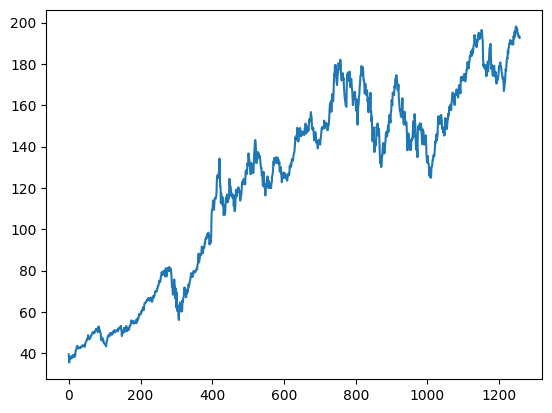

In [4]:
# extract and viz
dfc = df['Close']
plt.plot(dfc)

In [5]:
#Splitt´em up
dfcs = dfc.values.reshape(-1, 1)

train_data, test_data = train_test_split(dfcs, test_size=0.2, shuffle = False)

In [6]:
#Scal´it

scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [7]:
#Le Definé
def create_sequences(data, input_size, output_size):
    X, y = [], []
    for i in range(len(data) - input_size - output_size +1):
        X.append(data[i:i + input_size])
        y.append(data[i + input_size:i + input_size+output_size])
    return np.array(X), np.array(y)

In [8]:
input_size = 5
output_size = 3

train_X, train_y =create_sequences(train_scaled, input_size, output_size)
test_X, test_y = create_sequences(test_scaled, input_size, output_size)

In [9]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(999, 5, 1)
(999, 3, 1)
(245, 5, 1)
(245, 3, 1)


In [10]:
#build and chochoo
model = Sequential()
model.add(LSTM(100,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(RepeatVector(3))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 100)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 100)            80400     
                                                                 
 time_distributed (TimeDist  (None, 3, 1)              101       
 ributed)                                                        
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Choochooo

history = model.fit(train_X, train_y, epochs=500, batch_size=50,validation_split=0.2)

Epoch 1/500

16/16 [==============================] - 4s 46ms/step - loss: 0.2403 - val_loss: 0.4378
Epoch 2/500
16/16 [==============================] - 0s 13ms/step - loss: 0.1052 - val_loss: 0.1247
Epoch 3/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0473 - val_loss: 0.0736
Epoch 4/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0276 - val_loss: 0.0389
Epoch 5/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0095 - val_loss: 0.0175
Epoch 6/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0052 - val_loss: 0.0096
Epoch 7/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0036 - val_loss: 0.0067
Epoch 8/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 9/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 10/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.001

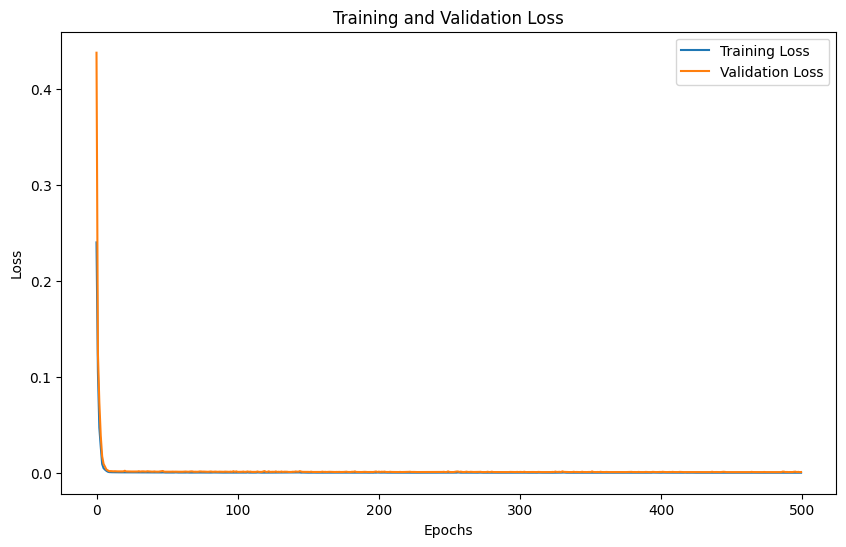

In [13]:
# Get the training and validation loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
#Reshape
test_input = test_X.reshape(test_X.shape)

#Predict
test_predicted = model.predict(test_input)

8/8 [==============================] - 1s 6ms/step


In [15]:
#inverse prediction values
test_predicted = test_predicted.flatten().reshape(-1, 1)
predicted_values = scaler.inverse_transform(test_predicted)

In [16]:
#inverese testy vals to actual vals
test_true_input = test_y.flatten().reshape(-1,1)
test_true = scaler.inverse_transform(test_true_input)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(test_true, predicted_values)
mae = mean_absolute_error(test_true, predicted_values)
r2 = r2_score(test_true, predicted_values)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 12.909876123128763
Mean Absolute Error (MAE): 2.9136727573109322
R-squared (R2) Score: 0.9519305470415959


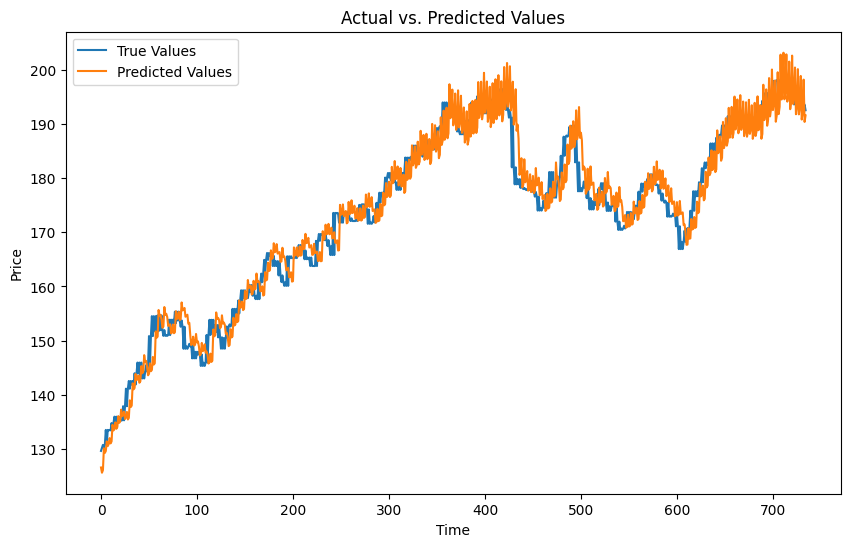

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(test_true, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [19]:
model.save('tizi.h5')

C:\Users\chris\Documents\1_spicy\000_datadrivendollars\ds-capstone\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
'''train_X_reshaped = train_X.reshape(-1, 1)
test_X_reshaped = test_X.reshape(-1, 1)

train_predicted = model.predict(train_X.reshape(train_X.shape))
test_predicted = model.predict(test_X.reshape(test_X.shape))
train_predicted = scaler.inverse_transform(train_predicted)
test_predicted = scaler.inverse_transform(test_predicted)

train_actual = scaler.inverse_transform(y_train)
test_actual = scaler.inverse_transform(y_test)
x1 = np.arange(0, len(train_actual))
x2 = np.arange(len(train_actual), len(train_actual)+len(test_actual))
plt.plot(x1,train_actual)
plt.plot(x1,train_predicted)
plt.plot(x2,test_actual)
plt.plot(x2,test_predicted)
plt.legend(['train_actual','train_predicted','test_actual','test_predicted'])
plt.vlines(x=int(len(train_actual)), color='r',linestyles='dashed', ymin = 0, ymax = max(test_actual))
plt.show()'''

"train_X_reshaped = train_X.reshape(-1, 1)\ntest_X_reshaped = test_X.reshape(-1, 1)\n\ntrain_predicted = model.predict(train_X.reshape(train_X.shape))\ntest_predicted = model.predict(test_X.reshape(test_X.shape))\ntrain_predicted = scaler.inverse_transform(train_predicted)\ntest_predicted = scaler.inverse_transform(test_predicted)\n\ntrain_actual = scaler.inverse_transform(y_train)\ntest_actual = scaler.inverse_transform(y_test)\nx1 = np.arange(0, len(train_actual))\nx2 = np.arange(len(train_actual), len(train_actual)+len(test_actual))\nplt.plot(x1,train_actual)\nplt.plot(x1,train_predicted)\nplt.plot(x2,test_actual)\nplt.plot(x2,test_predicted)\nplt.legend(['train_actual','train_predicted','test_actual','test_predicted'])\nplt.vlines(x=int(len(train_actual)), color='r',linestyles='dashed', ymin = 0, ymax = max(test_actual))\nplt.show()"